In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

## Load Data

In [2]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Sta_ID', 'Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

In [3]:
# Load satellite variables, grouped by ecological role / process
satellite_vars = [
    
    # 1. Phytoplankton biomass (state variables)
    'CHL',        # Chlorophyll-a concentration (GlobColour)
    'C',          # Phytoplankton carbon biomass from BBP443 (GlobColour)

    # 2. Phytoplankton community composition (Phytoplankton Functional Types)
    'DIATO',      # Diatoms (GlobColour)
    'DINO',       # Dinoflagellates (GlobColour)
    'GREEN',      # Green algae (GlobColour)
    'HAPTO',      # Haptophytes (GlobColour)
    'PROCHLO',    # Prochlorococcus (GlobColour)
    'PROKAR',     # Other prokaryotes / cyanobacteria (GlobColour)

    # 3. Phytoplankton size structure / traits
    'MICRO',      # Microphytoplankton fraction (GlobColour)
    'NANO',       # Nanophytoplankton fraction (GlobColour)
    'PICO',       # Picophytoplankton fraction (GlobColour)
    'MESD',       # Mean equivalent spherical diameter (derived from MICRO/NANO/PICO; GlobColour)

    # 4. Phytoplankton physiology & stoichiometry
    'CHL:C',      # Chlorophyll-to-carbon ratio (GlobColour)

    # 5. Optical properties & particle environment
    'BBP',        # Particulate backscattering coefficient (GlobColour)
    'CDM',        # Colored detrital & dissolved organic matter absorption (GlobColour)
    'SPM',        # Suspended particulate matter (GlobColour)

    # 6. Ocean color reflectance (sensor-level spectral info)
    'RRS412',     # Remote sensing reflectance at 412 nm (GlobColour)
    'RRS443',     # Remote sensing reflectance at 443 nm (GlobColour)
    'RRS490',     # Remote sensing reflectance at 490 nm (GlobColour)
    'RRS555',     # Remote sensing reflectance at 555 nm (GlobColour)
    'RRS670',     # Remote sensing reflectance at 670 nm (GlobColour)

    # 7. Water clarity & light attenuation
    'KD490',      # Diffuse attenuation coefficient at 490 nm (GlobColour)
    'ZSD',        # Secchi disk depth (GlobColour)

    # 8. Light forcing
    'PAR',        # Photosynthetically available radiation (EarthData L3/L4)

    # 9. Physical environment & mixing
    'SST',        # Sea surface temperature (OSYSSEA)
    'MLD',        # Mixed layer depth (Global Ocean Physics Reanalysis; mlotst)

    # 10. Surface forcing & circulation
    'u10',        # 10 m zonal wind (ERA5 daily statistics)
    'v10',        # 10 m meridional wind (ERA5 daily statistics)
    'wind_stress_curl',  # Wind stress curl (Calculated from ERA5 daily statistics)

    # 11. Nutrient environment
    'no3',        # Nitrate concentration (Global Ocean Biogeochemistry Hindcast)
]

satellite_data = {}
for var in satellite_vars:
    var_data = xr.open_dataset(f'satellite_features/{var}.nc')
    satellite_data[var] = var_data

## Look for Redundant Satellite Variables

In [4]:
def correlation_matrix(satellite_data):
    corr_df = pd.DataFrame()

    for var, ds in satellite_data.items():
        if var not in satellite_vars:
            continue
        # Flatten npp and spatial dims into one long vector
        corr_df[var] = ds['value_0'].values.reshape(-1)  # (npp * lat * lon,)
    
    # Drop rows where any variable is NaN
    corr_df = corr_df.dropna()
    corr_matrix = corr_df.corr(method='spearman')
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - corr_matrix.abs()
    
    # Hierarchical clustering
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    
    # Get the ordering from the dendrogram
    dendro = dendrogram(linkage_matrix, no_plot=True)
    order = dendro['leaves']
    ordered_vars = corr_matrix.columns[order]
    
    # Reorder correlation matrix
    corr_reordered = corr_matrix.loc[ordered_vars, ordered_vars]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        corr_reordered,
        ax=ax,
        cmap='RdBu_r',
        vmin=-1, vmax=1,
        center=0,
        annot=True,
        fmt='.2f',
        annot_kws={'size': 7},
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Pearson r'}
    )
    ax.set_title('Correlation Matrix (Satellite Variables)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_matrix

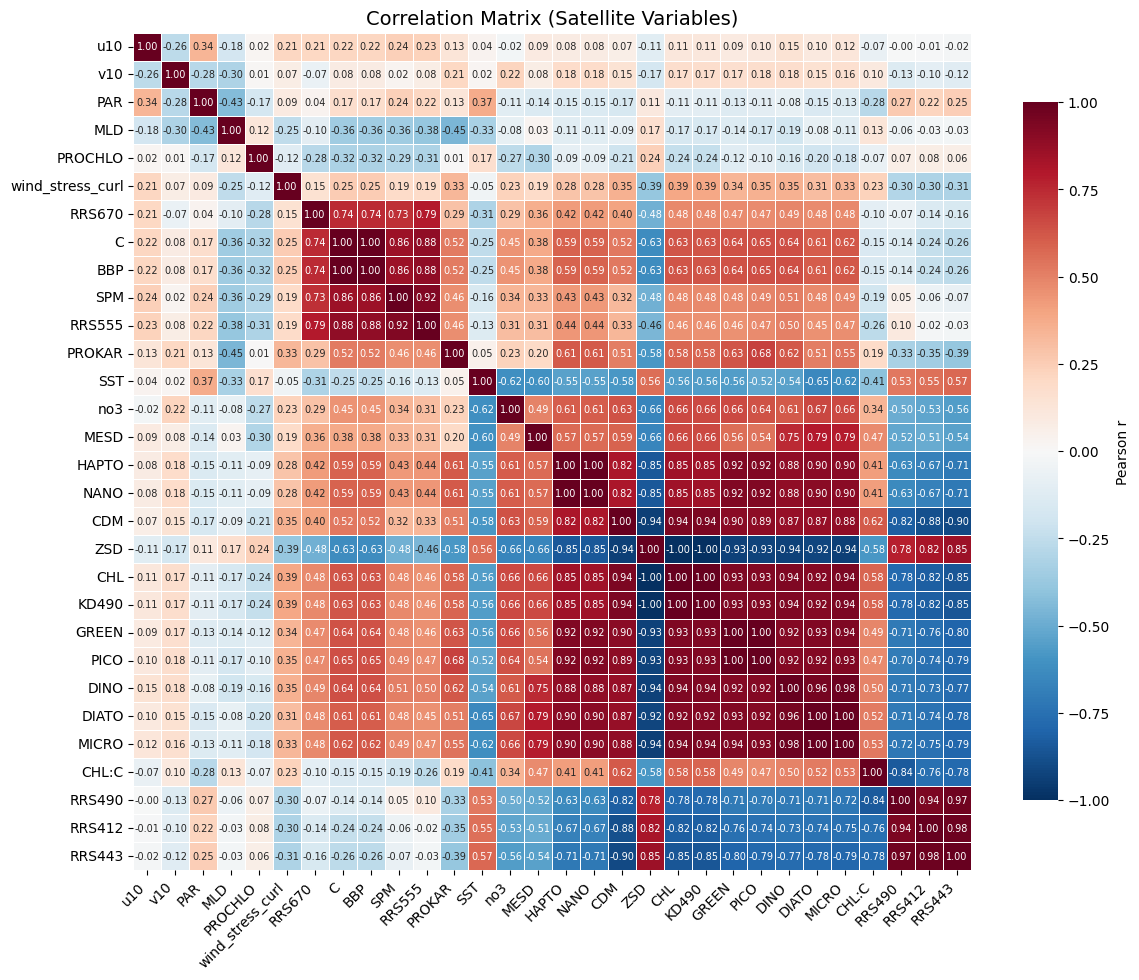

In [5]:
# Show correlations between satellite variables
corr_matrix = correlation_matrix(satellite_data)

## Choose Redundant Satellite Variables to Remove

In [6]:
print('Highly correlated variables:')
threshold = 0.95
pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

Highly correlated variables:
Pairs with correlation > 0.95:
NANO    HAPTO     1.000000
KD490   CHL       1.000000
BBP     C         1.000000
PICO    GREEN     0.996126
MICRO   DIATO     0.995467
RRS443  RRS412    0.983690
MICRO   DINO      0.977752
RRS490  RRS443    0.971305
DINO    DIATO     0.955961
ZSD     CHL      -1.000000
        KD490    -1.000000
dtype: float64


In [7]:
def plot_correlation(var1, var2, satellite_data, log_scale=False):
    x = satellite_data[var1]['value_0'].values.flatten()
    y = satellite_data[var2]['value_0'].values.flatten()
    
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    
    if log_scale:
        mask2 = (x > 0) & (y > 0)
        x, y = x[mask2], y[mask2]
    
    pearson_r = np.corrcoef(x, y)[0, 1]
    spearman_r, _ = stats.spearmanr(x, y)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(x, y, s=2, alpha=0.2)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_title(
        f'{var1} vs {var2} (pixel-level {"log-log" if log_scale else ""})\n'
        f'Pearson r = {pearson_r:.3f}, Spearman r = {spearman_r:.3f}, N = {len(x):,}'
    )
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

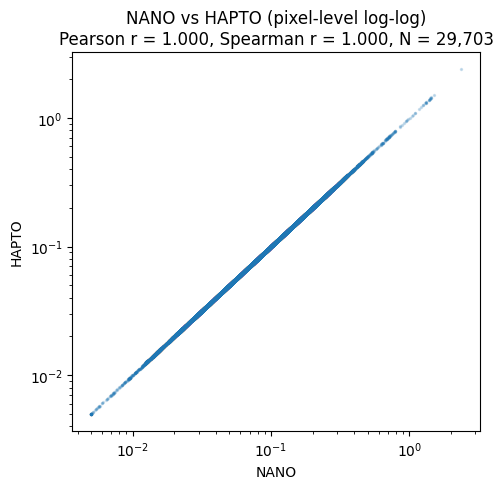

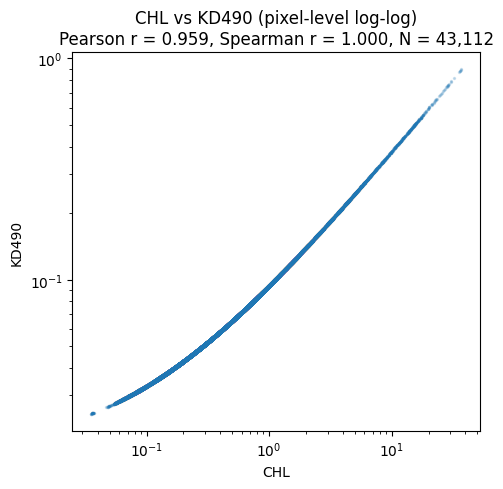

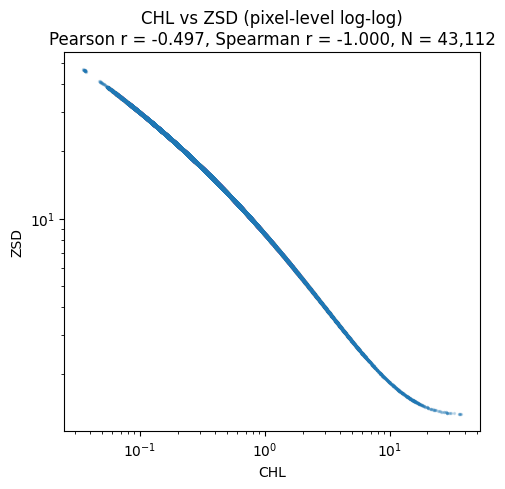

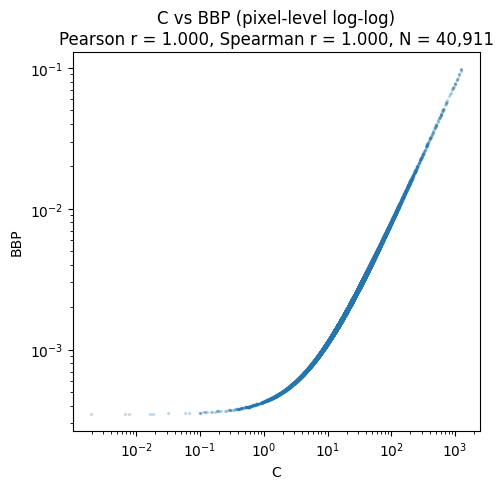

In [8]:
# Investigate specific pairs

## All these variable pairs are just rescalings of each other (no unique information for EDM models)
## Choosing to remove the following variables (somewhat arbitrary which one to choose):
##   - NANO
##   - KD490
##   - ZSD
##   - C

# NANO/HAPTO
plot_correlation('NANO', 'HAPTO', satellite_data, log_scale=True)

# CHL/KD490
plot_correlation('CHL', 'KD490', satellite_data, log_scale=True)

# CHL/ZSD
plot_correlation('CHL', 'ZSD', satellite_data, log_scale=True)

# C/BBP
plot_correlation('C', 'BBP', satellite_data, log_scale=True)

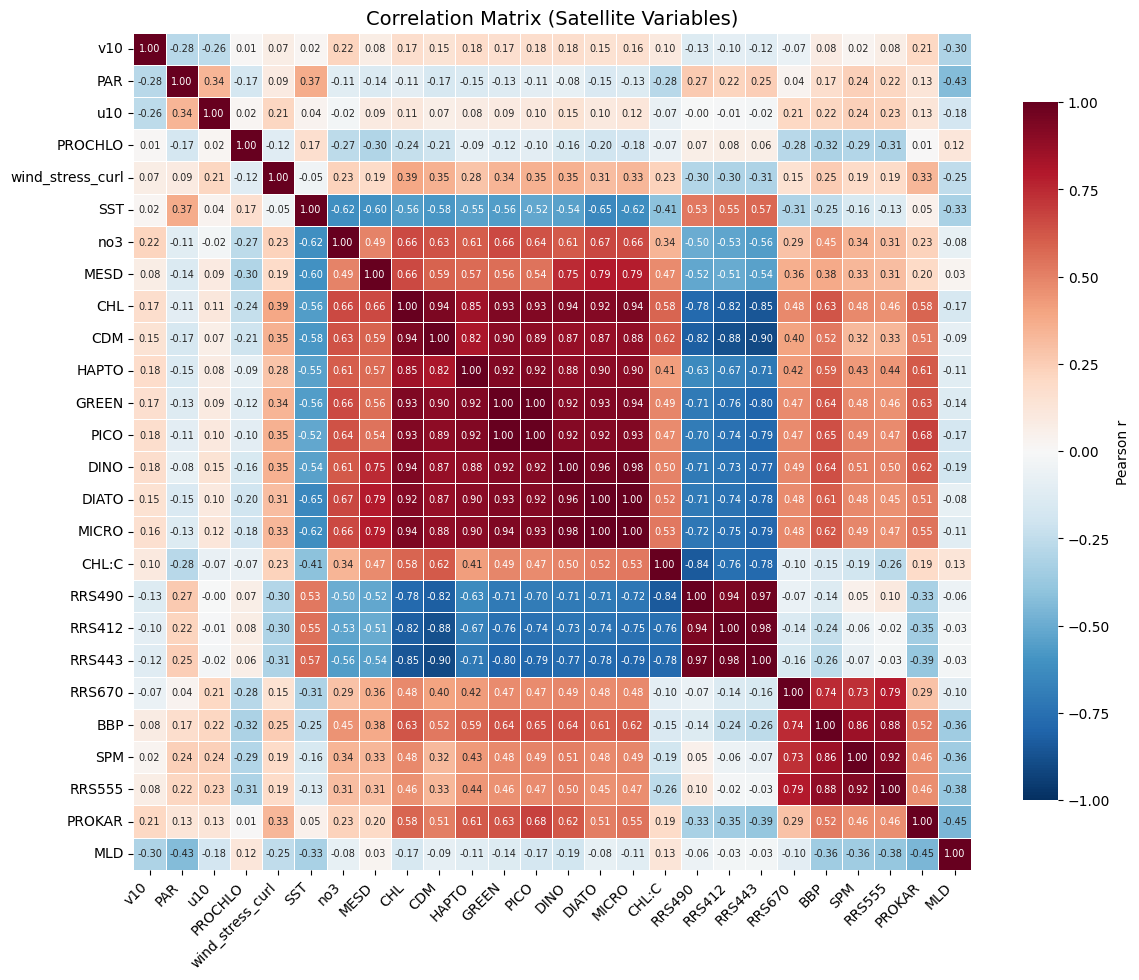

Highly correlated variables:
Pairs with correlation > 0.95:
PICO    GREEN     0.996126
MICRO   DIATO     0.995467
RRS443  RRS412    0.983690
MICRO   DINO      0.977752
RRS490  RRS443    0.971305
DINO    DIATO     0.955961
dtype: float64


In [9]:
# List of keys you want to remove
remove_keys = {'NANO', 'KD490', 'ZSD', 'C'}

# Create a new dictionary excluding those keys
satellite_data_new = {k: v for k, v in satellite_data.items() if k not in remove_keys}

# Show correlations between satellite variables (reduced dataset)
corr_matrix_new = correlation_matrix(satellite_data_new)

print('Highly correlated variables:')
threshold = 0.95
pairs = corr_matrix_new.where(np.triu(np.ones(corr_matrix_new.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

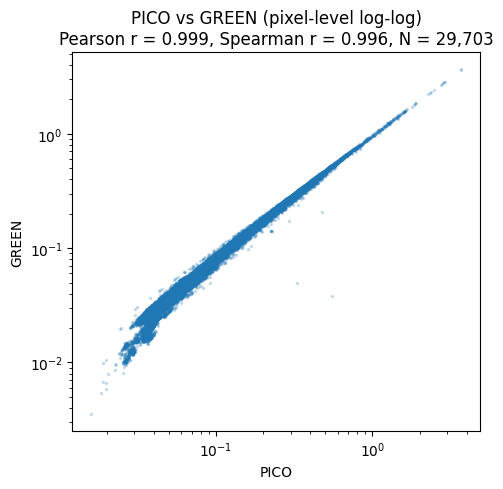

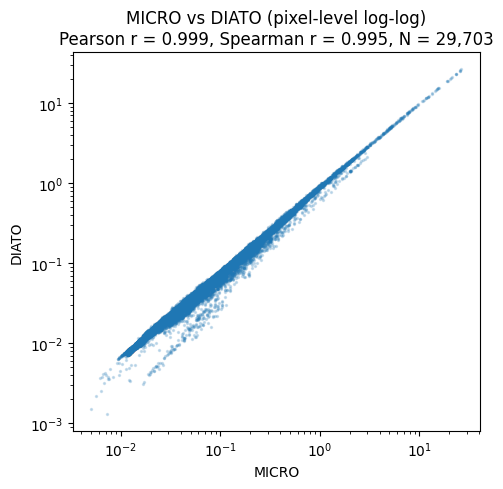

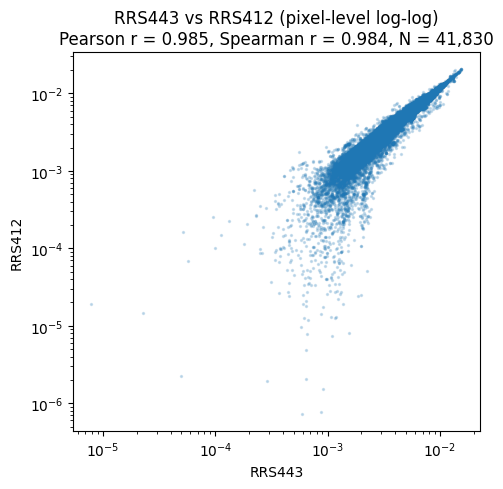

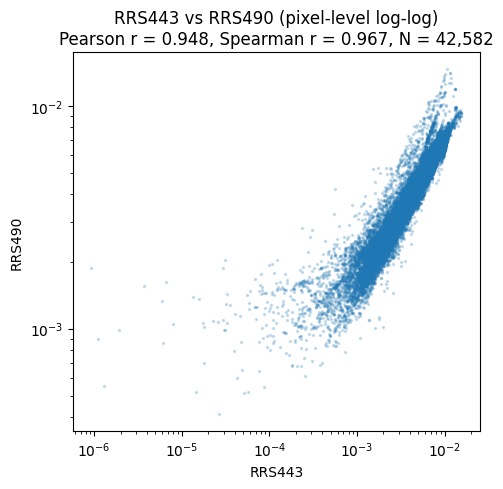

In [10]:
# Investigate specific pairs

## These variables have some unique information, but are very highly correlated (little unique information for EDM models)
## Choosing to remove the following variables (somewhat arbitrary which one to choose):
##   - PICO
##   - MICRO
##   - RRS412
##   - RRS490

# PICO/GREEN
plot_correlation('PICO', 'GREEN', satellite_data, log_scale=True)

# MICRO/DIATO
plot_correlation('MICRO', 'DIATO', satellite_data, log_scale=True)

# RRS443/RRS412
plot_correlation('RRS443', 'RRS412', satellite_data, log_scale=True)

# RRS443/RRS490
plot_correlation('RRS443', 'RRS490', satellite_data, log_scale=True)

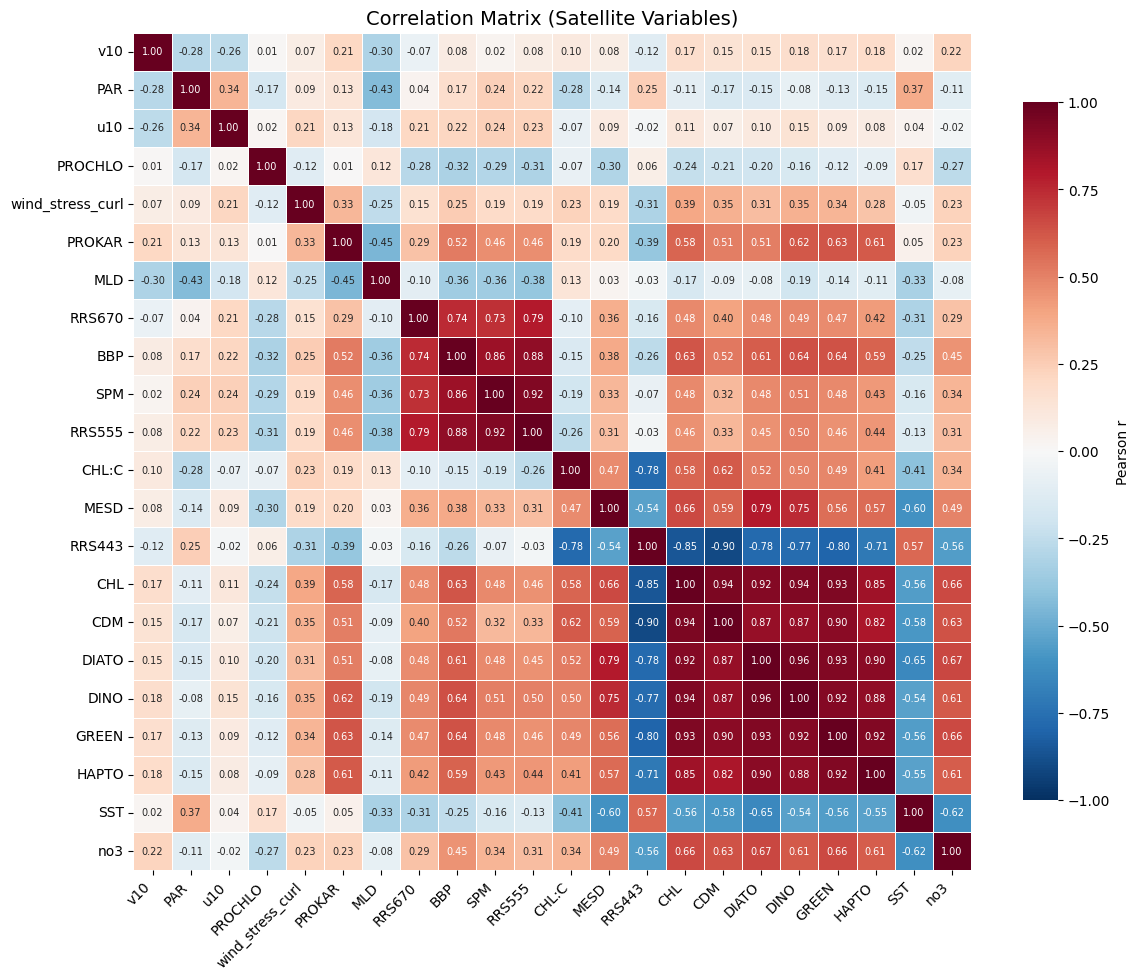

Highly correlated variables:
Pairs with correlation > 0.95:
DINO  DIATO    0.955961
dtype: float64


In [11]:
# List of keys you want to remove
remove_keys = {'NANO', 'KD490', 'ZSD', 'C', 'PICO', 'MICRO', 'RRS412', 'RRS490'}

# Create a new dictionary excluding those keys
satellite_data_new = {k: v for k, v in satellite_data.items() if k not in remove_keys}

# Show correlations between satellite variables (reduced dataset)
corr_matrix_new = correlation_matrix(satellite_data_new)

print('Highly correlated variables:')
threshold = 0.95
pairs = corr_matrix_new.where(np.triu(np.ones(corr_matrix_new.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

We are left with a reduced dataset of satellite variables that contain mostly non-redundant information for nearest-neighbor searches. This will make the code more efficient as it will reduce the number of possible embeddings of satellite data.

In [ ]:
remove_keys = {'NANO', 'KD490', 'ZSD', 'C', 'PICO', 'MICRO', 'RRS412', 'RRS490'}